<h1 align="center">INTRADAY TRADING MODEL</h1>

This notebook investigates an intraday trading approach that blends insights from both daily and real-time (intraday) data. It utilizes a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model, trained on historical daily data, to forecast volatility and identify the daily trend. This volatility prediction is then combined with technical indicators like RSI and Bollinger Bands applied to intraday data to generate buy and sell signals.

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings('ignore')

## Importing Daily and Intraday Data

In [2]:
daily_df=pd.read_csv("simulated_daily_data.csv",parse_dates=True)
intra_df=pd.read_csv("simulated_5min_data.csv",parse_dates=True)

In [3]:
daily_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
0,9/17/2014,116.466003,117.043503,113.105499,114.333504,114.333504,21056800.0,NaN
1,9/18/2014,114.214996,114.214996,103.276001,106.110001,106.110001,34483200.0,NaN
2,9/19/2014,106.025749,106.958748,96.133003,98.698998,98.698998,37919700.0,NaN
3,9/20/2014,98.668251,105.823998,97.470749,102.225998,102.225998,36863600.0,NaN
4,9/21/2014,102.021248,103.106499,98.295250,99.705254,99.705254,26580100.0,NaN


In [4]:
# Dropping unnecessary columns
daily_df.drop(columns=["Unnamed: 7"],inplace=True)

In [5]:
daily_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
intra_df.head()

,datetime,open,low,high,close,volume,Unnamed: 6
0,9/29/2021 20:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
1,9/29/2021 20:05,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2,9/29/2021 20:10,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
3,9/29/2021 20:15,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
4,9/29/2021 20:20,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN


In [7]:
intra_df.drop(columns=["Unnamed: 6"],inplace=True)

In [8]:
intra_df.isna().sum()

datetime    0
open        0
low         0
high        0
close       0
volume      0
dtype: int64

In [9]:
intra_df.shape

(177877, 6)

In [10]:
daily_df.shape

(3289, 7)

## Data Preparation

The variable of interest in GARCH model is log(yt/yt-1) = log(yt) - log(yt-1), the logarithm of the ratio of this time’s value to last time’s value. So, before actually fitting the model, we have to first check if our series, on which we'll fit the model, is stationary or not. If not, we have to first make that series stationary and then find the parameters of GARCH model. This all can be done using one single function which will be discussed later.

In [11]:
daily_df["log_ret"]=np.log(daily_df["Adj Close"]).diff()

In [12]:
daily_df.dropna(inplace=True)

In [13]:
daily_df["Et"]=daily_df["log_ret"]-(daily_df["log_ret"].mean())
x=daily_df["Et"]*daily_df["Et"]

### ADF test for stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(x,autolag="AIC")
p_value=dftest[1]
Test_statistic=dftest[0]
p_value

4.9533022991206976e-30

### KPSS Test for stationarity

In [15]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(x,regression="c",nlags="auto")
p_value2=kpss_test[1]
p_value2

0.1

From both the tests, it can be concluded that the **series is stationary**.
<br>To automate the process of computing the values of the parameters of GARCH model, we'll use the 'auto_arima' function from 'pmdarima' library and find the best set of parameters which will fit the series.

In [16]:
from pmdarima import auto_arima

auto_fit = auto_arima(x,trace=True,suppress_warnings=True,information_criterion='bic')
auto_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-25320.773, Time=2.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-25288.431, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-25334.608, Time=1.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-25330.863, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-25057.187, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-25329.803, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-25330.810, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-25321.876, Time=0.77 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-25168.840, Time=0.44 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 7.758 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3288
Model:               SARIMAX(1, 0, 0)   Log Likelihood               12679.451
Date:                Fri, 12 Jul 2024   AIC                         -25352.902
Time:                        00:32:54   BIC                         -25334.608
Sample:                             0   HQIC                        -25346.352
                               - 3288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      7.918      0.000       0.001       0.002
ar.L1          0.1280      0.006     20.351      0.000       0.116       0.140
sigma2      2.618e-05   4.97e-08    526.560      0.000    2.61e-05    2.63e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):         130357563.99
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            24.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       977.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# Extracting the parameters for GARCH model
p_arch = auto_fit.get_params().get("order")[0]
o_arch = auto_fit.get_params().get("order")[1]
q_arch = auto_fit.get_params().get("order")[2]

## Applying GARCH Model

We will employ a 180-day rolling window to fit the GARCH model. This will allow us to capture evolving market dynamics. Using the fitted model, we can then forecast the volatility for the next trading day.

In [18]:
# Fitting the GARCH model
def pred_volatility(x):
    model=arch_model(y=x,p=p_arch,o=o_arch,q=q_arch).fit()
    volatility=model.forecast(horizon=1).variance.iloc[-1,0]
    return volatility

In [19]:
# Forecasting the future volatility
daily_df["pred_vol"]=daily_df["log_ret"].rolling(180).apply(pred_volatility)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 254427.03495108566
Iteration:      2,   Func. Count:     14,   Neg. LLF: -206.6614212626073
Iteration:      3,   Func. Count:     21,   Neg. LLF: -306.2661319660049
Iteration:      4,   Func. Count:     26,   Neg. LLF: 622321.9207894956
Iteration:      5,   Func. Count:     31,   Neg. LLF: -300.538644502441
Iteration:      6,   Func. Count:     36,   Neg. LLF: 125125.25766713015
Iteration:      7,   Func. Count:     41,   Neg. LLF: -322.308942087756
Iteration:      8,   Func. Count:     45,   Neg. LLF: -322.34532828064994
Iteration:      9,   Func. Count:     49,   Neg. LLF: -322.3488295024314
Iteration:     10,   Func. Count:     53,   Neg. LLF: -322.34889071808266
Iteration:     11,   Func. Count:     57,   Neg. LLF: -322.3488911902878
Optimization terminated successfully    (Exit mode 0)
            Current function value: -322.3488911902878
            Iterations: 11
            Function evaluations: 57
            Gradient eval

In [20]:
#pd.set_option("display.max_rows",None)

In [21]:
daily_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,log_ret,Et,pred_vol
3284,9/14/2023,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.010563,0.000335
3285,9/15/2023,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.001360,0.000193
3286,9/16/2023,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,-0.002757,0.000291
3287,9/17/2023,6641.981934,6654.499512,6611.268555,6633.546875,6633.546875,6.774211e+09,-0.001284,-0.002522,0.000191
3288,9/18/2023,6633.248535,6853.683594,6603.878906,6688.570313,6688.570313,1.561534e+10,0.008261,0.007023,0.000304


In [22]:
daily_df.dropna(inplace=True)

## Computing daily signals

The daily signal will be used to examine the daily upward or downward trend. For that we'll calculate the actual variance of 'log_ret' column on 180-day rolling window. Previously, we calculated the predicted variance and this time it's the the actual variance. We'll use the predicted variance and actual variance to find the **'premium'**. Premium is nothing but the change in predicted variance from the actual variance, and is used to indicate the direction of volatility.

In [23]:
daily_df["variance"]=daily_df["log_ret"].rolling(180).var()
daily_df["premium"]=(daily_df["pred_vol"]-daily_df["variance"])/daily_df["variance"]

In [24]:
# Changing Date column to datetime
daily_df["Date"]=pd.to_datetime(daily_df["Date"])

We'll compare the premium of each day with its standard deviation which is again calculated on a 180-day rolling window.
<br>Based on the comparison between the premium and its standard deviation:
- **Long Position (Signal = 1):** If the premium is significantly higher than its standard deviation, it suggests the market is experiencing higher than usual volatility. This might indicate an upward trend, and we assign a "1" signal for a potential long position.
- **Short Position (Signal = -1):** Conversely, if the premium is significantly lower than its standard deviation, it suggests lower than expected volatility. This could be a sign of a downtrend, and we assign a "-1" signal for a potential short position.
- **Hold Position (Signal = 0):** If the premium falls within the range of its standard deviation, it indicates the market volatility is behaving as predicted by the model. In this case, we assign a "0" signal, signifying a hold position and no action is taken.
<br>
<br>The daily signals generated represent our prediction for the market movement on the next day.  However,  these signals are currently aligned with the day they were calculated on.  To evaluate the effectiveness of these predictions, we need to shift them forward by one day so they are aligned with the actual price movements they were designed to forecast.

In [25]:
# Calculating standard devaiation on 180-day rolling window
daily_df["premium_std"]=daily_df["premium"].rolling(180).std()

# Generating the daily signal
n=len(daily_df)
w=np.empty(n)
u=daily_df["premium"].values
v=daily_df["premium_std"].values
for i in range(n):
    if (u[i]>v[i]):
        w[i]=1
    elif (u[i]<v[i]*-1):
        w[i]=-1
    else:
        w[i]=0
daily_df["daily_signal"]=w

# Shifting the daily signal to next time point
daily_df["daily_signal"]=daily_df["daily_signal"].shift()

## Merging Daily and Intraday Data

In [26]:
intra_df.set_index("datetime",inplace=True)

In [27]:
intra_df.index=pd.to_datetime(intra_df.index)

In [28]:
daily_df.set_index("Date",inplace=True)

In [29]:
daily_df.dropna(inplace=True)

**Aligning Daily Signals with Intraday Data:**
- **Resampling Daily Data:** We will convert the daily data (which likely has one data point per day) into a higher frequency format, typically with timestamps every 5 minutes. This process, called "resampling," allows us to match the daily signals with the intraday data.
- **Assigning Daily Signal to Intraday Data:** Since the daily signal represents the predicted movement for the entire day, we will assign the same daily signal value (1, -1, or 0) to all the 5-minute time points within that particular day. This essentially replicates the daily prediction throughout the day.

In [30]:
df=daily_df.resample('5min').min()

In [31]:
df['daily_signal'] = df.groupby(pd.Grouper(freq='1D'))['daily_signal'].transform('first')

In [32]:
df=df.loc[df.index>="9/29/2021 20:00"]

In [33]:
# Merging daily and intraday data
final_df = pd.merge(intra_df.reset_index(),df["daily_signal"].reset_index(),how="left",left_on="datetime",right_on="Date")

In [34]:
final_df["datetime"]=pd.to_datetime(final_df["datetime"])
final_df.set_index("datetime",inplace=True)

In [35]:
final_df.dropna(inplace=True)

In [36]:
final_df.head()

,open,low,high,close,volume,Date,daily_signal
datetime,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29 20:00:00,0.0
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29 20:05:00,0.0
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29 20:10:00,0.0
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29 20:15:00,0.0
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29 20:20:00,0.0


In [37]:
final_df.drop(columns="Date",inplace=True)

In [38]:
final_df["daily_signal"].value_counts()

daily_signal
 0.0    137701
-1.0     29244
 1.0     10224
Name: count, dtype: int64

## Computing Intraday Signals

We will utilize two technical indicators, the Relative Strength Index (RSI) and Bollinger Bands, to generate intraday signals that complement the daily prediction. Here's the logic:
- **Long Signal (1):** If the closing price for a 5-minute interval is higher than the upper Bollinger Band and the RSI value is above 70, this suggests a strong upward trend. We assign a "1" signal for a potential buying opportunity.
- **Short Signal (-1):** Conversely, if the closing price falls below the lower Bollinger Band and the RSI is below 30, it might indicate a downtrend. We assign a "-1" signal for a potential short selling opportunity.
- **Hold (0):** In any other scenario where the price and RSI values don't meet the criteria for long or short signals, we assign a "0" signal, suggesting holding the current position and taking no action.

In [39]:
# Calculating RSI and Upper & Lower Bollinger Bands
import pandas_ta as pd_ta

final_df["RSI"]=pd_ta.rsi(close=final_df["close"],length=20)
final_df["lbands"]=pd_ta.bbands(close=final_df["close"],length=20).iloc[:,0]
final_df["ubands"]=pd_ta.bbands(close=final_df["close"],length=20).iloc[:,2]

In [40]:
# Assigning Intraday Signals
x=final_df["close"]
u=final_df["RSI"].values
v=final_df["lbands"].values
w=final_df["ubands"].values
n=len(u)
sig=np.empty(n)

for i in range(n):
    if((u[i]>70)&(x[i]>w[i])):
        sig[i]=1
    elif((u[i]<30)&(x[i]<v[i])):
        sig[i]=-1
    else:
        sig[i]=0

final_df["intra_signal"]=sig

In [41]:
final_df.head(5)

,open,low,high,close,volume,daily_signal,RSI,lbands,ubands,intra_signal
datetime,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,0.0,NaN,NaN,NaN,0.0
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,0.0,NaN,NaN,NaN,0.0
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,0.0,NaN,NaN,NaN,0.0
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,0.0,NaN,NaN,NaN,0.0
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,0.0,NaN,NaN,NaN,0.0


Previously, we shifted the daily signal forward by one day to align it with the actual daily price movements. To achieve proper synchronization, we now need to mirror that shift for the intraday signals. By shifting the intraday signal forward by one time point (5 minutes), both signals will be aligned and predict price movements for the same upcoming period.

In [42]:
final_df["intra_signal"]=final_df["intra_signal"].shift()

In [43]:
final_df["intra_signal"].dropna(inplace=True)

Now it's time to merge daily and intraday signals to obtain the final "return signal" for trading decisions.
- If daily and intraday signals agree (short-short or long-long), the return signal inherits the common direction (short or long).
- If signals disagree, the return signal is marked as "unclear" (not a number).
- The final return signals are stored in a new column "return_signal" in the dataframe.

In [44]:
u=final_df["daily_signal"].values
v=final_df["intra_signal"].values
n=len(u)
ret_sig=np.empty(n)

for i in range(n):
    if((u[i]==-1)&(v[i]==-1)):
        ret_sig[i]=-1
    elif((u[i]==1)&(v[i]==1)):
        ret_sig[i]=1
    else:
        ret_sig[i]=np.nan
        
final_df["return_signal"]=ret_sig

This strategy focuses on generating a single buy or sell signal for each day based on the combined daily and intraday signals. Once a signal is triggered (long or short), the position is held throughout the rest of the trading day. This approach avoids frequent intraday trading and aims to capitalize on the predicted market direction for the entire day.

In [45]:
final_df['return'] = np.log(final_df['close']).diff()
final_df['return_signal'] = final_df.groupby(pd.Grouper(freq='D'))['return_signal'].transform(lambda x: x.ffill())
final_df['return_signal'].fillna(0,inplace=True)

To assess the effectiveness of our trading strategy, we calculate the daily strategy return. This is achieved by multiplying the daily return (price change) with the corresponding "return signal" (1 for long, -1 for short, 0 for hold). This calculation essentially reflects the profit or loss for each day based on the signals generated by our strategy.

In [46]:
final_df['forward_return'] = final_df['return'].shift(-1)
final_df['strategy_return'] = final_df['forward_return']*final_df['return_signal']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

In [47]:
final_df['return_signal'].value_counts()

return_signal
 0.0    161780
-1.0     12565
 1.0      2824
Name: count, dtype: int64

In [48]:
final_df.tail()

,open,low,high,close,volume,daily_signal,RSI,lbands,ubands,intra_signal,return_signal,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,
2023-09-17 23:40:00,6664.7050,6661.1500,6671.5,6664.9700,15,0.0,61.155476,6629.649976,6681.104024,0.0,0.0,0.000040,0.000328,0.0
2023-09-17 23:45:00,6665.0150,6664.8500,6675.5,6667.1575,28,0.0,62.134056,6634.283430,6680.336320,0.0,0.0,0.000328,-0.000069,-0.0
2023-09-17 23:50:00,6667.1550,6666.5000,6674.5,6666.7000,18,0.0,61.791356,6641.534587,6677.272413,0.0,0.0,-0.000069,-0.000052,-0.0
2023-09-17 23:55:00,6666.7000,6661.8375,6674.5,6666.3525,50,0.0,61.520062,6649.081927,6673.327073,0.0,0.0,-0.000052,0.000202,0.0
2023-09-18 00:00:00,6666.3525,6665.9000,6675.5,6667.7000,24,0.0,62.197522,6651.504479,6672.910771,0.0,0.0,0.000202,NaN,NaN


## Plotting Cumulative Strategy Return

Strategy return refers to the performance of the strategy measured as a percentage return. It reflects how much money the strategy would have made or lost compared to the initial investment, if it were followed exactly.

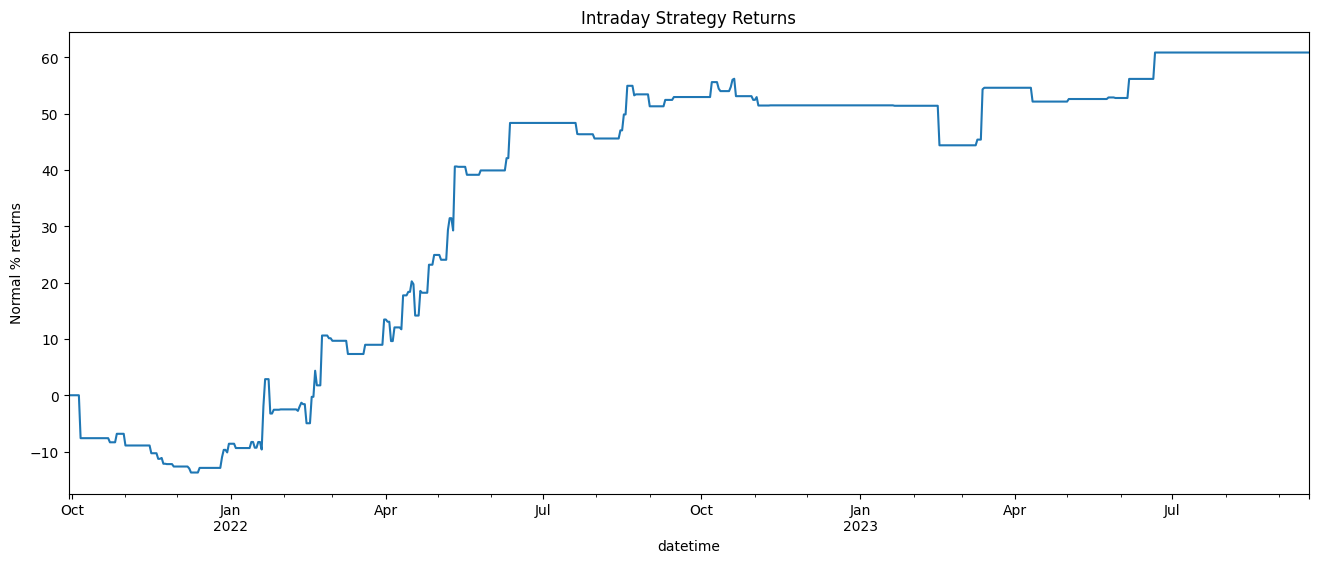

In [49]:
(((np.exp(daily_return_df.cumsum())-1)*100)).plot(figsize=(16,6))
plt.title('Intraday Strategy Returns')
plt.ylabel("Normal % returns")
plt.show()

## Calculating Win Ratio

Win ratio in trading refers to the percentage of winning trades a trader or strategy executes. It's a simple metric calculated by dividing the number of profitable trades by the total number of trades placed over a specific period.
<br>
<br> **Win Ratio** = (Number of Winning Trades) / (Total Number of Trades)

In [50]:
def validity(x):
    if x>0:
        return 1
    elif x<0:
        return -1

In [51]:
daily_return_df = pd.DataFrame(daily_return_df)
daily_return_df = daily_return_df.iloc[:-1,:]
daily_return_df["Check"] = daily_return_df["strategy_return"].apply(validity)

In [52]:
daily_return_df[["validation1","Validation2"]] = final_df.groupby(pd.Grouper(freq='D'))['return_signal'].agg(["min","max"])

In [53]:
daily_return_df["ret_sig_sign"] = daily_return_df["validation1"] + daily_return_df["Validation2"]

In [54]:
# Number of winning trades
u=daily_return_df[((daily_return_df["Check"]>0)&(daily_return_df["ret_sig_sign"]>0)) | ((daily_return_df["Check"]<0)&(daily_return_df["ret_sig_sign"]<0))]
correct=u.Check.count()
correct

49

In [55]:
# Total number of trades
total = daily_return_df["Check"].dropna().count()
total

97

In [56]:
# Win Ratio
win_ratio = correct/total
print("Win Ratio:", win_ratio*100,"%")

Win Ratio: 50.51546391752577 %
